In [1]:
import torch 
import torch.nn as nn
import torch.nn as nn
import numpy as np 
import matplotlib.pyplot as plt

# CUDA support 
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

In [2]:
def oscillator(d, w0, x):
    
    """
    @author: bmoseley
    Defines the analytical solution to the 1D underdamped harmonic oscillator problem. 
    Equations taken from: https://beltoforion.de/en/harmonic_oscillator/
    """
    assert d < w0
    w = np.sqrt(w0**2-d**2)
    phi = np.arctan(-d/w)
    A = 1/(2*np.cos(phi))
    cos = np.cos(phi+w*x)
    sin = np.sin(phi+w*x)
    exp = np.exp(-d*x)
    y  = exp*2*A*cos
    return y

In [3]:
d, w0 = 2, 20

In [4]:
x = np.linspace(0,1,500)
x_test=np.linspace(1,2,500)

In [5]:
x = np.array([x for _ in range(100)])
x_test= np.array([x_test for _ in range(100)])


(100, 500) (100, 500)


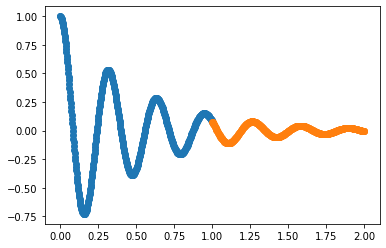

In [6]:

N = 100 # number of samples

y = oscillator(d, w0, x).astype(np.float32)
y_test =oscillator(d, w0, x_test).astype(np.float32)
print(x.shape,y.shape)
plt.scatter(x[1],y[1])
plt.scatter(x_test[1],y_test[1])

In [7]:
class LSTM(nn.Module):
    
    def __init__(self, hidden_layers=64,outputs=1 ):
        super(LSTM, self).__init__()
        self.hidden_layers = hidden_layers
        # lstm1, lstm2, linear are all layers in the network
        
        self.lstm1 = nn.LSTMCell(1, self.hidden_layers)
        self.lstm2 = nn.LSTMCell(self.hidden_layers, self.hidden_layers)
        self.linear = nn.Linear(self.hidden_layers, outputs)
        self.optimizer = torch.optim.LBFGS(self.parameters(), lr=0.8)

        
        
        
    def forward(self, y, future_preds=0):
        outputs, num_samples = [], y.size(0)
        h_t = torch.zeros(num_samples, self.hidden_layers, dtype=torch.float32)
        c_t = torch.zeros(num_samples, self.hidden_layers, dtype=torch.float32)
        h_t2 = torch.zeros(num_samples, self.hidden_layers, dtype=torch.float32)
        c_t2 = torch.zeros(num_samples, self.hidden_layers, dtype=torch.float32)
        
        for time_step in y.split(1, dim=1):
            # N, 1
            h_t, c_t = self.lstm1(time_step, (h_t, c_t)) # initial hidden and cell states
            h_t2, c_t2 = self.lstm2(h_t, (h_t2, c_t2)) # new hidden and cell states
            output = self.linear(h_t2) # output from the last FC layer
            outputs.append(output)
            
        for i in range(future_preds):
            # this only generates future predictions if we pass in future_preds>0
            # mirrors the code above, using last output/prediction as input
            h_t, c_t = self.lstm1(output, (h_t, c_t))
            h_t2, c_t2 = self.lstm2(h_t, (h_t2, c_t2))
            output = self.linear(h_t2)
            outputs.append(output)
            
        # transform list to tensor    
        outputs = torch.cat(outputs, dim=1)
        return outputs
    
    

2 min 

In [9]:

# set random seed to 0
np.random.seed(0)
torch.manual_seed(0)
# load data and make training set
inpu = torch.from_numpy(y[3:, :-1])
target = torch.from_numpy(y[3:, 1:])
test_input = torch.from_numpy(y[:3, :-1])
test_target = torch.from_numpy(y[:3, 1:])
# build the model
seq = LSTM()
criterion = nn.MSELoss()
# use LBFGS as optimizer since we can load the whole data to train

#begin to train
eje_x = np.linspace(0,2,1498)
for i in range(10):
    print('STEP: ', i)
    def closure():
        seq.optimizer.zero_grad()
        out = seq(inpu)
        loss = criterion(out, target)
        print('loss:', loss.item())
        loss.backward()
        return loss
    seq.optimizer.step(closure)
    # begin to predict, no need to track gradient here
    with torch.no_grad():
        future = 500
        pred = seq.forward(test_input, future_preds=future)
        loss = criterion(pred[:, :-future], test_target)
        print('test loss:', loss.item())
        y = pred.detach().numpy()
    # draw the result
    plt.figure(figsize=(30,10))
    plt.title('Predict future values for time sequences\n(Dashlines are predicted values)', fontsize=30)
    plt.xlabel('x', fontsize=20)
    plt.ylabel('y', fontsize=20)
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    d_t=len(y[:inpu.size(1)][0])
    plt.scatter(np.linspace(0,2,d_t), y[:inpu.size(1)][0], linewidth = 2.0)
    plt.savefig('plots_lstm/predict%d.jpg'%i)
    plt.close()

STEP:  0
loss: 0.1396332085132599
loss: 0.13158999383449554
loss: 0.12615422904491425
loss: 0.1252409964799881
loss: 0.1235985979437828
loss: 0.11951195448637009
loss: 0.10805456340312958
loss: 0.024462604895234108
loss: 0.02245509624481201
loss: 0.021421214565634727
loss: 0.006910533178597689
loss: 0.005198265425860882
loss: 0.004944779444485903
loss: 0.004915028344839811
loss: 0.004750629886984825
loss: 0.004457108210772276
loss: 0.0038176379166543484
loss: 0.002758422400802374
loss: 0.0012832175707444549
loss: 0.0006300709210336208
test loss: 0.0005763949011452496
STEP:  1
loss: 0.0005763949593529105
loss: 0.0005427870783023536
loss: 0.000539297005161643
loss: 0.0005366987898014486
loss: 0.0005305015947669744
loss: 0.0005192933022044599
loss: 0.000500545313116163
loss: 0.00047110908781178296
loss: 0.00042232227860949934
loss: 0.0003654086322057992
loss: 0.0003462787135504186
loss: 0.0003442013403400779
loss: 0.0003431352670304477
loss: 0.00034230135497637093
loss: 0.0003408108896110